# 7. Model Interpretability and Implementation
* File: `predict_model.ipynb`
* This will include
    1) `Running and saving the best model`: Ensuring that features are properly aligned to those that will be used in the prediction and for saving.
    2) `Demonstrate feature importance`: Plot features and their scores in descending order.
    3) `Save and Load the Model`: Load your trained model from the specified path using an appropriate library like joblib.
    4) `Model Interpretability`: Anchor/explain top features, provide global summaries of the model, audit and detect biases.
    5) `Make Predictions`: Use the loaded model to make predictions based on the preprocessed data.
    6) `A brief conclusion`

## 7.1 Running and Saving the Best Model

In [2]:
# Import librabries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib

In [3]:
# Load cleaned and transformed data
df = pd.read_csv('../../data/processed/selecteddata.csv')

In [4]:
# Separate features and target
X = df.drop(['Target'], axis=1)
y = df['Target']

In [7]:
# Plot the best model with feature decoding definitions

# Step 1: Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Handling Imbalance (SMOTE)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# Convert X_train and X_test back to DataFrame with original column names
X_train_df = pd.DataFrame(X_train, columns=X.columns)
X_test_df = pd.DataFrame(X_test, columns=X.columns)

# Instantiate the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Define a parameter grid
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    rf_model, 
    param_grid, 
    cv=5, 
    scoring='accuracy', 
    n_jobs=-1, 
    verbose=2
)

# Fit the model using GridSearchCV
grid_search.fit(X_train_df, y_train)

# Evaluate the best model
best_rf = grid_search.best_estimator_
y_pred_rf = best_rf.predict(X_test_df)

# Model Metrics
accuracy = accuracy_score(y_test, y_pred_rf)
conf_matrix = confusion_matrix(y_test, y_pred_rf)
class_report = classification_report(y_test, y_pred_rf, output_dict=True)

# Print the model metrics
print("Best parameters found: ", grid_search.best_params_)
print("Random Forest Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_report(y_test, y_pred_rf))


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters found:  {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Random Forest Accuracy: 0.9720457433290979
Confusion Matrix:
 [[271   7   0]
 [  7 240   3]
 [  0   5 254]]
Classification Report:
               precision    recall  f1-score   support

           2       0.97      0.97      0.97       278
           3       0.95      0.96      0.96       250
           4       0.99      0.98      0.98       259

    accuracy                           0.97       787
   macro avg       0.97      0.97      0.97       787
weighted avg       0.97      0.97      0.97       787



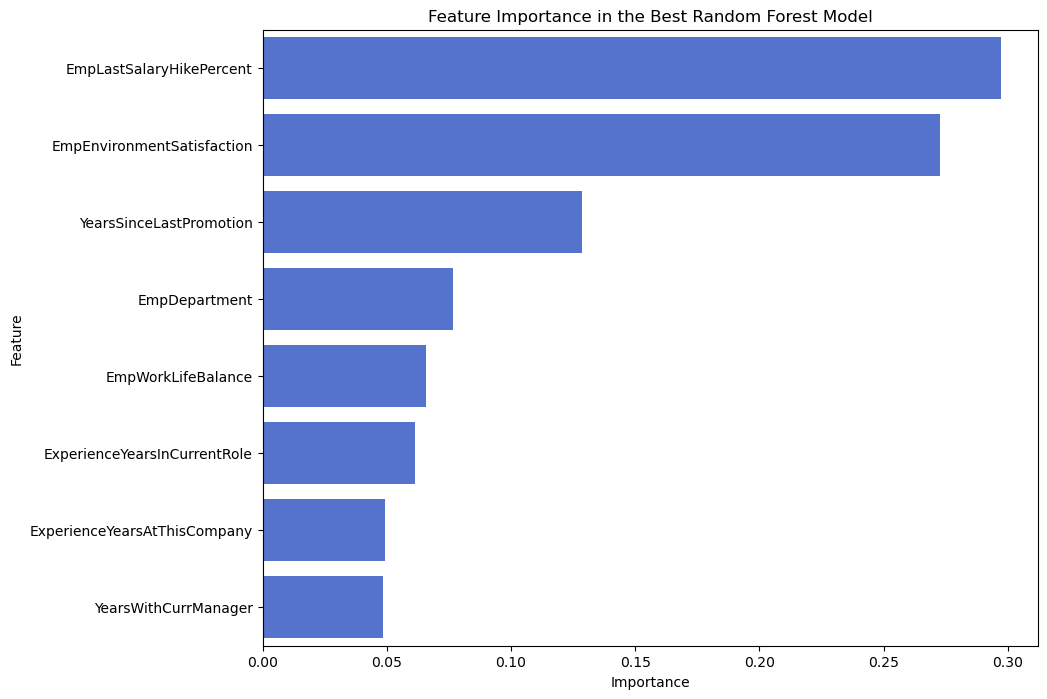

In [9]:
# Check if the number of features matches the length of feature_importances_
if len(best_rf.feature_importances_) == X_train_df.shape[1]:
    feature_importances = best_rf.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': X_train_df.columns,
        'Importance': feature_importances
    })

    # Sort by importance
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # Plot the feature importances
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df, color='royalblue')
    plt.title('Feature Importance in the Best Random Forest Model')
    plt.show()
else:
    print("Error: The number of features does not match the length of feature importances.")


In [10]:
# Initialize SHAP explainer with the best model
explainer = shap.TreeExplainer(best_rf)

In [11]:
# Calculate SHAP values for the test dataset
shap_values = explainer.shap_values(X_test_df)

In [12]:
print(type(shap_values))
print(dir(shap_values))


<class 'numpy.ndarray'>
['T', '__abs__', '__add__', '__and__', '__array__', '__array_finalize__', '__array_function__', '__array_interface__', '__array_prepare__', '__array_priority__', '__array_struct__', '__array_ufunc__', '__array_wrap__', '__bool__', '__class__', '__class_getitem__', '__complex__', '__contains__', '__copy__', '__deepcopy__', '__delattr__', '__delitem__', '__dir__', '__divmod__', '__dlpack__', '__dlpack_device__', '__doc__', '__eq__', '__float__', '__floordiv__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__iadd__', '__iand__', '__ifloordiv__', '__ilshift__', '__imatmul__', '__imod__', '__imul__', '__index__', '__init__', '__init_subclass__', '__int__', '__invert__', '__ior__', '__ipow__', '__irshift__', '__isub__', '__iter__', '__itruediv__', '__ixor__', '__le__', '__len__', '__lshift__', '__lt__', '__matmul__', '__mod__', '__mul__', '__ne__', '__neg__', '__new__', '__or__', '__pos__', '__pow__', '__radd__', '__rand__', '__rdi

In [13]:
print(X_test_df.columns)


Index(['EmpDepartment', 'EmpEnvironmentSatisfaction',
       'EmpLastSalaryHikePercent', 'EmpWorkLifeBalance',
       'ExperienceYearsAtThisCompany', 'ExperienceYearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager'],
      dtype='object')


In [14]:
# Print the type of shap_values to ensure it's as expected
print(type(shap_values))


<class 'numpy.ndarray'>


In [15]:
# Check SHAP values type and shape
print("Type of shap_values:", type(shap_values))

if isinstance(shap_values, np.ndarray):
    # If SHAP values are a numpy array
    print("SHAP values shape:", shap_values.shape)
    
    # If it's a 2D array (for binary classification or regression)
    if len(shap_values.shape) == 2:
        shap_values_for_class = shap_values
    elif len(shap_values.shape) == 3:
        # If it's a 3D array (multi-class classification)
        print("SHAP values are in a 3D array format. Please specify class index.")
        class_index = 0  # Change this based on your needs
        shap_values_for_class = shap_values[:, :, class_index]
    else:
        raise ValueError("Unexpected SHAP values array shape.")
else:
    raise ValueError("Unexpected SHAP values format.")

Type of shap_values: <class 'numpy.ndarray'>
SHAP values shape: (787, 8, 3)
SHAP values are in a 3D array format. Please specify class index.


In [16]:
# 1. Create a list of features
features = X_train_df.columns
features

Index(['EmpDepartment', 'EmpEnvironmentSatisfaction',
       'EmpLastSalaryHikePercent', 'EmpWorkLifeBalance',
       'ExperienceYearsAtThisCompany', 'ExperienceYearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager'],
      dtype='object')

In [17]:
# 2. Set up SHAP explainer
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_test_df)

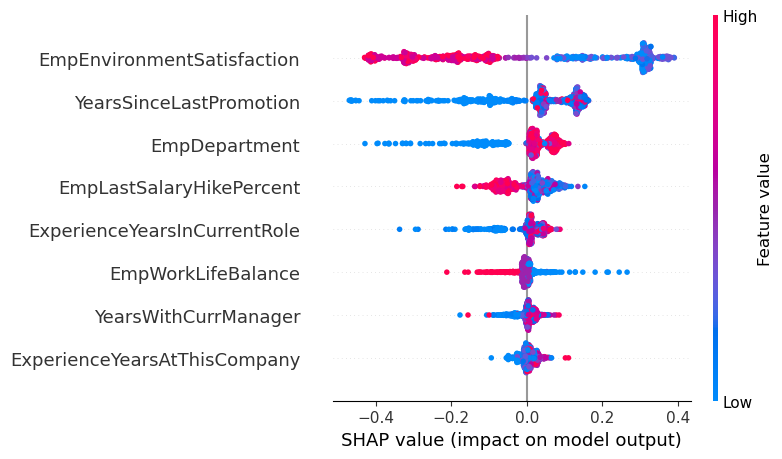

In [18]:
# 3. Summary plot for the specific class
shap.summary_plot(shap_values_for_class, X_test_df)

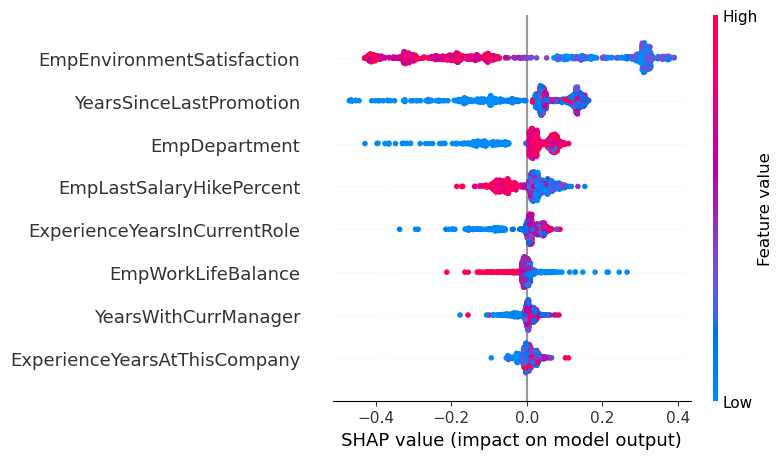

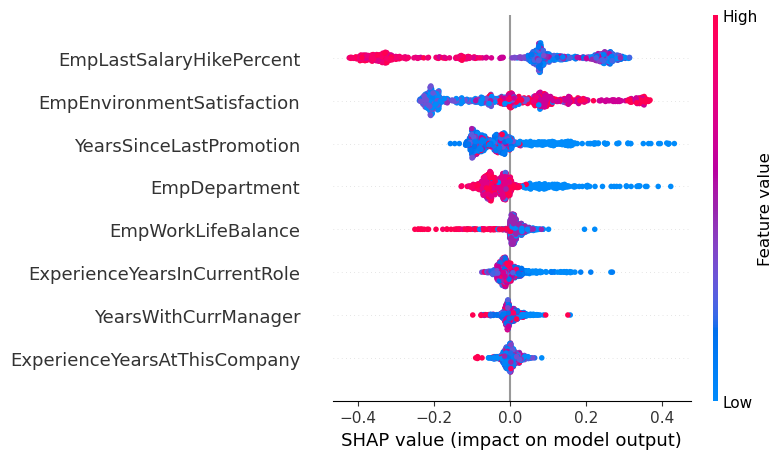

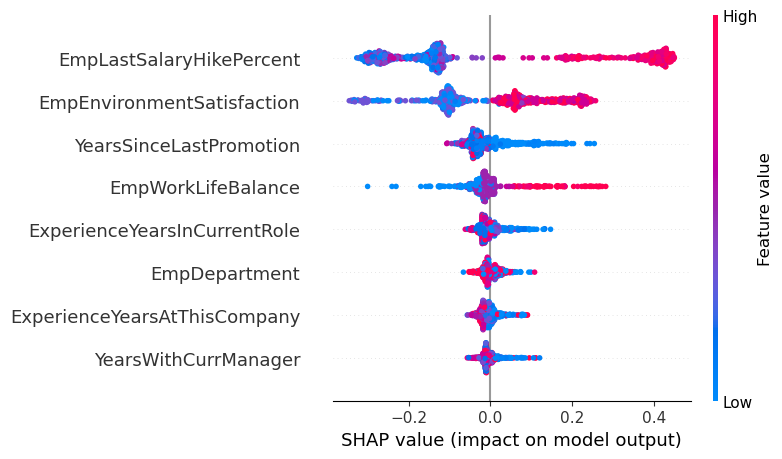

In [19]:
# 4. Display SHAP plots for different target values (if applicable)
for i in range(shap_values.shape[2]):
    shap_values_for_class = shap_values[:, :, i].reshape(-1, shap_values.shape[1])
    shap.summary_plot(shap_values_for_class, X_test_df, title=f"Summary Plot for Class {i}")


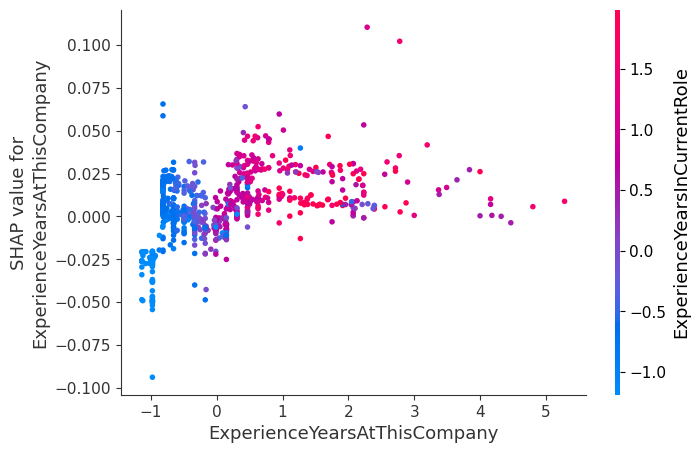

In [20]:
# 5. Dependence Plot for a specific feature
feature_name = 'ExperienceYearsAtThisCompany'
if feature_name in X_test_df.columns:
    try:
        shap.dependence_plot(
            feature_name, 
            shap_values[:, :, class_index],  # SHAP values for the specified class
            X_test_df, 
            interaction_index="ExperienceYearsInCurrentRole"
        )
    except Exception as e:
        print("Error in dependence plot:", e)
else:
    print(f"Feature '{feature_name}' not found in X_test_df columns.")

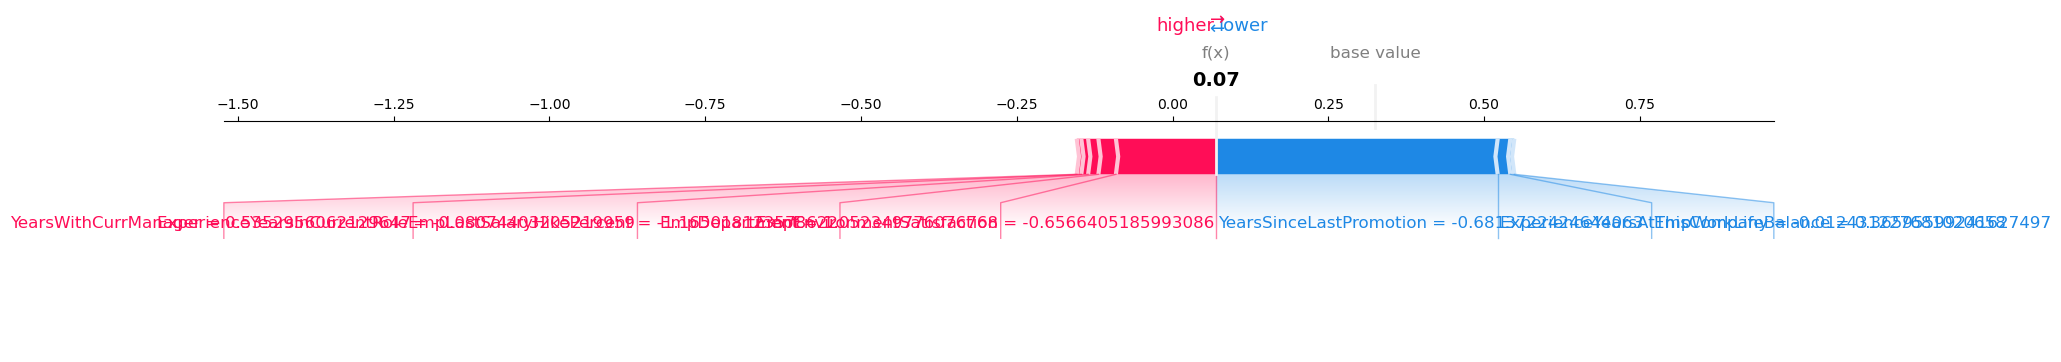

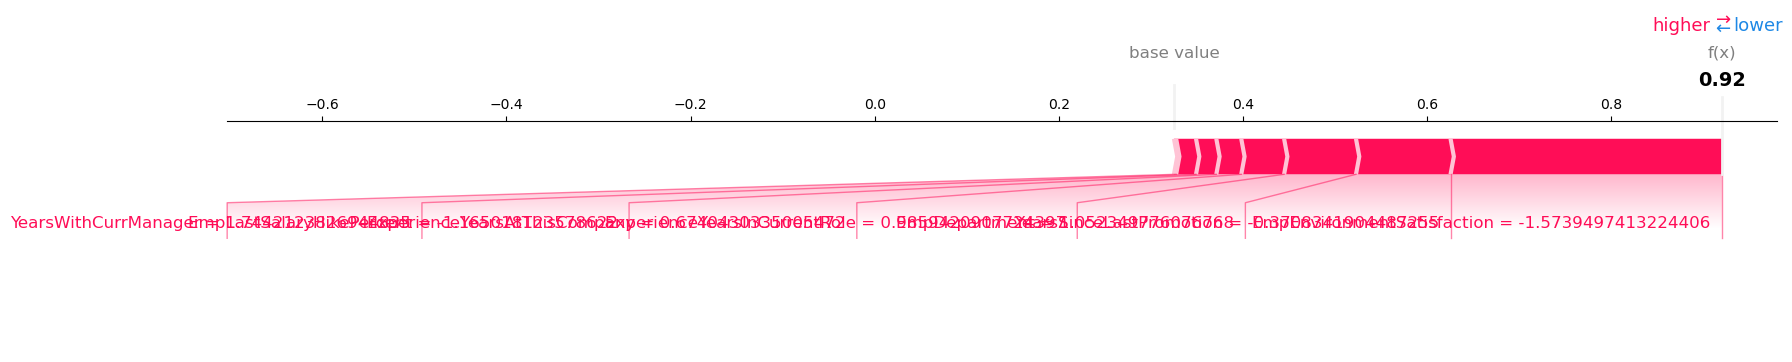

In [21]:
# 6. Force Plot for specific instances and classes
# Select specific instances for visualization
instance_indices = [0, 6]  # Example indices, adjust as needed
for idx in instance_indices:
    shap.plots.force(
        explainer.expected_value[class_index], 
        shap_values[idx, :, class_index],  # SHAP values for the specified class
        X_test_df.iloc[idx, :],
        matplotlib=True
    )

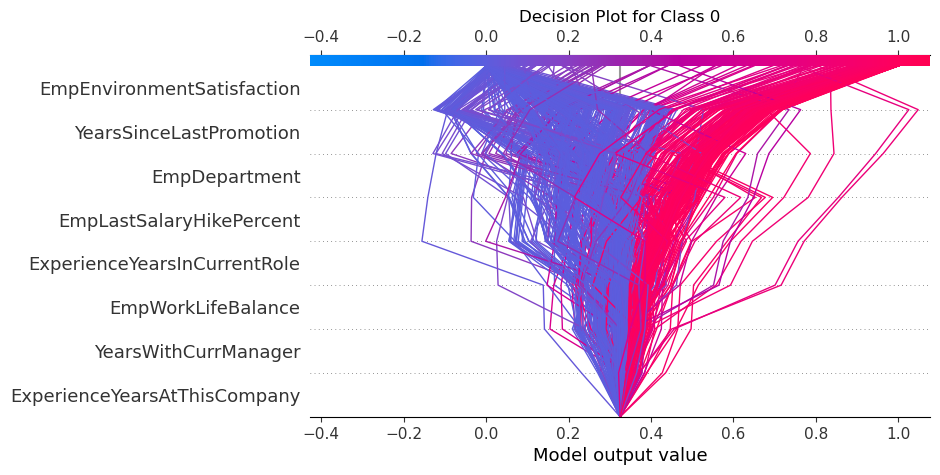

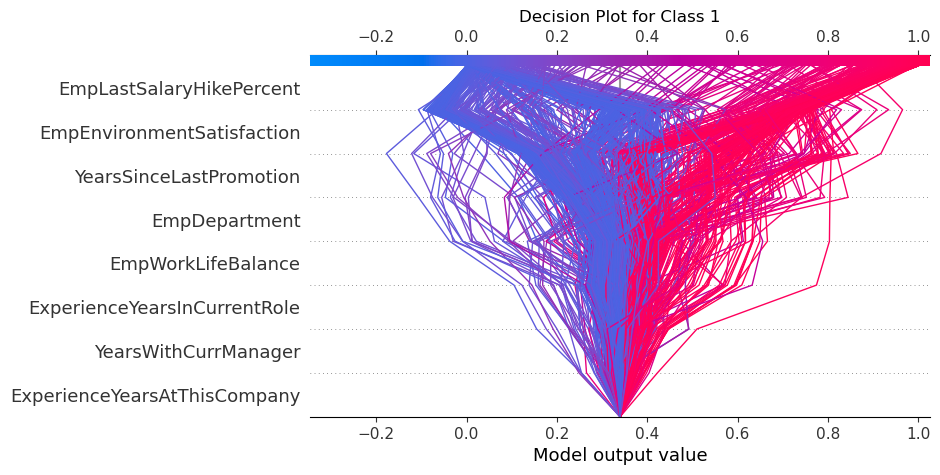

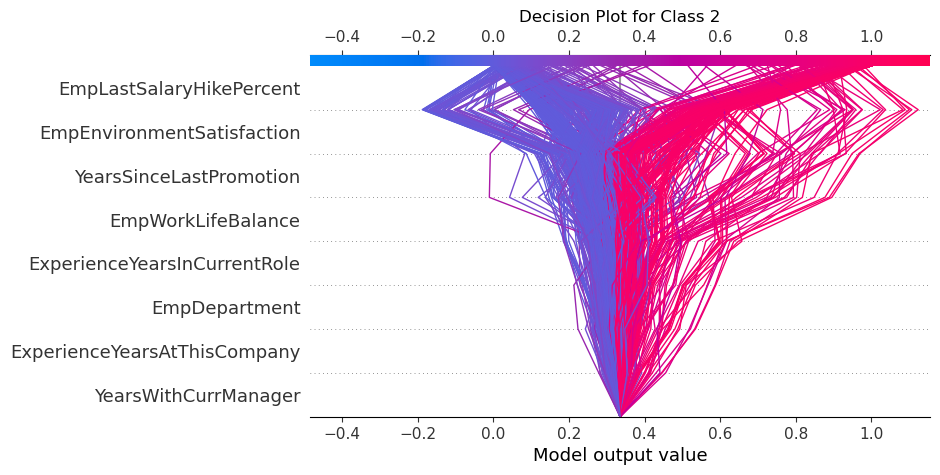

In [22]:
# 7. Decision plot for different classes
for i in range(shap_values.shape[2]):
    shap.decision_plot(
        explainer.expected_value[i],
        shap_values[:, :, i],  # SHAP values for the i-th class
        X_test_df.columns,
        title=f"Decision Plot for Class {i}"
    )

In [23]:
# 8. Save the best model
joblib.dump(best_rf, '../../data/processed/best_model.pkl')

['../../data/processed/best_model.pkl']

In [24]:
# Load the saved model
model_path = '../../data/processed/best_model.pkl'
model = joblib.load(model_path)

# Check the model type
print(type(model))


<class 'sklearn.ensemble._forest.RandomForestClassifier'>


In [25]:
# Convert X_train back to DataFrame
X_train_df = pd.DataFrame(X_train, columns=X.columns)

# Now you can print the columns
print("X_train columns:", X_train_df.columns)


X_train columns: Index(['EmpDepartment', 'EmpEnvironmentSatisfaction',
       'EmpLastSalaryHikePercent', 'EmpWorkLifeBalance',
       'ExperienceYearsAtThisCompany', 'ExperienceYearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager'],
      dtype='object')


In [27]:
# Check the feature names
features

Index(['EmpDepartment', 'EmpEnvironmentSatisfaction',
       'EmpLastSalaryHikePercent', 'EmpWorkLifeBalance',
       'ExperienceYearsAtThisCompany', 'ExperienceYearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager'],
      dtype='object')

In [29]:
# Load the saved model test 1
model_path = '../../data/processed/best_model.pkl'
model = joblib.load(model_path)

# Print model details for debugging
print(f"Model type: {type(model)}")
print(f"Number of classes: {model.n_classes_}")

# Define user data
user_data = {
    'EmpDepartment': [0],
    'EmpEnvironmentSatisfaction': [90],  # Example value
    'EmpLastSalaryHikePercent': [60],   # Example value
    'EmpWorkLifeBalance': [100],          # Example value
    'ExperienceYearsAtThisCompany': [0], # Example value
    'ExperienceYearsInCurrentRole': [0], # Example value
    'YearsSinceLastPromotion': [0],     # Example value
    'YearsWithCurrManager': [10]         # Example value
    
}

# Convert user data to a DataFrame
user_df = pd.DataFrame(user_data)

# Ensure the DataFrame columns match the model's expected feature names
feature_names = ['EmpDepartment', 'EmpEnvironmentSatisfaction', 'EmpLastSalaryHikePercent',
                  'EmpWorkLifeBalance', 'ExperienceYearsAtThisCompany',
                  'ExperienceYearsInCurrentRole', 'YearsSinceLastPromotion',
                  'YearsWithCurrManager']

user_df = user_df[feature_names]  # Reorder columns if necessary

# Get predictions and probabilities
predictions = model.predict(user_df)
probabilities = model.predict_proba(user_df)

# Print probabilities for debugging
print("Probabilities for each class:", probabilities)

# Handle multi-class classification
if probabilities.shape[1] > 1:
    # Get the class index with the highest probability
    predicted_class = np.argmax(probabilities[0])
    predicted_probability = probabilities[0][predicted_class] * 100  # Convert to percentage
else:
    # For binary classification
    predicted_class = predictions[0]
    predicted_probability = probabilities[0][predicted_class] * 100  # Convert to percentage

# Print the results
print(f"Your predicted Performance Rating is {predicted_class} and this has been with at least {predicted_probability:.2f}% accuracy.")


Model type: <class 'sklearn.ensemble._forest.RandomForestClassifier'>
Number of classes: 3
Probabilities for each class: [[0.02 0.1  0.88]]
Your predicted Performance Rating is 2 and this has been with at least 88.00% accuracy.


In [30]:
# Load the saved model test 2
model_path = '../../data/processed/best_model.pkl'
model = joblib.load(model_path)

# Print model details for debugging
# print(f"Model type: {type(model)}")
# print(f"Number of classes: {model.n_classes_}")

# Define user data
user_data = {
    'EmpDepartment': [0],
    'EmpEnvironmentSatisfaction': [2],  # Example value
    'EmpLastSalaryHikePercent': [1],   # Example value
    'EmpWorkLifeBalance': [0],          # Example value
    'ExperienceYearsAtThisCompany': [0], # Example value
    'ExperienceYearsInCurrentRole': [10], # Example value
    'YearsSinceLastPromotion': [30],     # Example value
    'YearsWithCurrManager': [1]         # Example value
}

# Convert user data to a DataFrame
user_df = pd.DataFrame(user_data)

# Ensure the DataFrame columns match the model's expected feature names
feature_names = ['EmpDepartment', 'EmpEnvironmentSatisfaction', 'EmpLastSalaryHikePercent',
                  'EmpWorkLifeBalance', 'ExperienceYearsAtThisCompany',
                  'ExperienceYearsInCurrentRole', 'YearsSinceLastPromotion',
                  'YearsWithCurrManager']

user_df = user_df[feature_names]  # Reorder columns if necessary

# Get predictions and probabilities
predictions = model.predict(user_df)
probabilities = model.predict_proba(user_df) if hasattr(model, 'predict_proba') else None

# Extract predicted class and its probability
predicted_class = predictions[0]
predicted_class_index = model.classes_.tolist().index(predicted_class)
predicted_class_probability = probabilities[0][predicted_class_index] * 100 if probabilities is not None else None

# Display results in the specified format
print(f"Your Predicted Performance Rating is {predicted_class} at an estimated Probability of {predicted_class_probability:.2f}%.")


Your Predicted Performance Rating is 3 at an estimated Probability of 87.00%.


In [31]:
# Load the saved model test 3
model_path = '../../data/processed/best_model.pkl'
model = joblib.load(model_path)

# Define user data
user_data = {
    'EmpDepartment': [0],
    'EmpEnvironmentSatisfaction': [0],  # Example value
    'EmpLastSalaryHikePercent': [0],   # Example value
    'EmpWorkLifeBalance': [0],          # Example value
    'ExperienceYearsAtThisCompany': [0], # Example value
    'ExperienceYearsInCurrentRole': [0], # Example value
    'YearsSinceLastPromotion': [0],     # Example value
    'YearsWithCurrManager': [0]         # Example value
}

# Convert user data to a DataFrame
user_df = pd.DataFrame(user_data)

# Ensure the DataFrame columns match the model's expected feature names
feature_names_from_model = ['EmpDepartment', 'EmpEnvironmentSatisfaction', 'EmpLastSalaryHikePercent',
                  'EmpWorkLifeBalance', 'ExperienceYearsAtThisCompany',
                  'ExperienceYearsInCurrentRole', 'YearsSinceLastPromotion',
                  'YearsWithCurrManager']

# Reorder columns if necessary
user_df = user_df[feature_names_from_model]  

# Get predictions and probabilities
predictions = model.predict(user_df)
probabilities = model.predict_proba(user_df) if hasattr(model, 'predict_proba') else None

# Define possible performance ratings
possible_ratings = [1, 2, 3, 4]

# Check if class 1 is missing from model classes
missing_classes = [rating for rating in possible_ratings if rating not in model.classes_]

# Check if the model's prediction includes a missing class
default_class = missing_classes[0] if missing_classes else None

# Extract predicted class and its probability
predicted_class = predictions[0]
predicted_class_index = model.classes_.tolist().index(predicted_class) if predicted_class in model.classes_ else None
predicted_class_probability = probabilities[0][predicted_class_index] * 100 if probabilities is not None and predicted_class_index is not None else None

# Check if class 1 is needed and handle accordingly
if default_class is not None:
    if predicted_class not in possible_ratings:
        print(f"Model did not predict a valid class. Assuming default class {default_class}.")
        predicted_class = default_class
        predicted_class_probability = 100.0  # Assume class 1 with certainty if missing classes are involved
    else:
        print(f"Your Predicted Performance Rating is {predicted_class} at an estimated Probability of {predicted_class_probability:.2f}%.")
else:
    print(f"Your Predicted Performance Rating is {predicted_class} at an estimated Probability of {predicted_class_probability:.2f}%.")


Your Predicted Performance Rating is 2 at an estimated Probability of 47.50%.


In [32]:
# Load the saved model test 4
model_path = '../../data/processed/best_model.pkl'
model = joblib.load(model_path)

# Define user data
user_data = {
    'EmpDepartment': [0],
    'EmpEnvironmentSatisfaction': [0],  # Example value
    'EmpLastSalaryHikePercent': [30],    # Example value
    'EmpWorkLifeBalance': [0],          # Example value
    'ExperienceYearsAtThisCompany': [0],# Example value
    'ExperienceYearsInCurrentRole': [0],# Example value
    'YearsSinceLastPromotion': [0],     # Example value
    'YearsWithCurrManager': [40]         # Example value
}

# Convert user data to a DataFrame
user_df = pd.DataFrame(user_data)

# Ensure the DataFrame columns match the model's expected feature names
feature_names_from_model = ['EmpDepartment', 'EmpEnvironmentSatisfaction', 'EmpLastSalaryHikePercent',
                            'EmpWorkLifeBalance', 'ExperienceYearsAtThisCompany',
                            'ExperienceYearsInCurrentRole', 'YearsSinceLastPromotion',
                            'YearsWithCurrManager']

# Reorder columns if necessary
user_df = user_df[feature_names_from_model]  

# Get predictions and probabilities
predictions = model.predict(user_df)
probabilities = model.predict_proba(user_df) if hasattr(model, 'predict_proba') else None

# Define possible performance ratings
possible_ratings = [1, 2, 3, 4]

# Extract predicted class and its probability
predicted_class = predictions[0]

# If class 1 is not in the model's predicted classes, manually handle it
if 1 not in model.classes_:
    # Assign class 1 if conditions are severe enough (e.g., all zero input)
    if np.sum(user_df.values) == 0:
        predicted_class = 1
        predicted_class_probability = 100.0
    else:
        predicted_class_index = model.classes_.tolist().index(predicted_class)
        predicted_class_probability = probabilities[0][predicted_class_index] * 100 if probabilities is not None else None
else:
    predicted_class_index = model.classes_.tolist().index(predicted_class)
    predicted_class_probability = probabilities[0][predicted_class_index] * 100 if probabilities is not None else None

# Display the result
if predicted_class == 1:
    print(f"Your Predicted Performance Rating is {predicted_class} with an assumed Probability of {predicted_class_probability:.2f}%.")
else:
    print(f"Your Predicted Performance Rating is {predicted_class} at an estimated Probability of {predicted_class_probability:.2f}%.")


Your Predicted Performance Rating is 4 at an estimated Probability of 88.00%.
